In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
import torch

In [2]:
import cigin

## Loading the model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = cigin.model.CIGINModel().to(device)
model.load_state_dict(torch.load('../weights/best_model.pth'))
model.eval()

CIGINModel(
  (solute_gather): GatherModel(
    (lin0): Linear(in_features=42, out_features=42, bias=True)
    (set2set): Set2Set(
      n_iters=2
      (lstm): LSTM(84, 42)
    )
    (message_layer): Linear(in_features=84, out_features=42, bias=True)
    (conv): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=10, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=1764, bias=True)
      )
      (res_fc): Identity()
    )
  )
  (solvent_gather): GatherModel(
    (lin0): Linear(in_features=42, out_features=42, bias=True)
    (set2set): Set2Set(
      n_iters=2
      (lstm): LSTM(84, 42)
    )
    (message_layer): Linear(in_features=84, out_features=42, bias=True)
    (conv): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=10, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=1764, bias=True)
      )
      (res_fc): Identity()
    )
  )
  (fc1): Linear

### Predicting free energy of solvation

In [7]:
solute = 'CC(=O)C'
solvent = 'C1=CC=C(C=C1)O'
data = cigin.dataset.data_to_loader(solute, solvent)

In [8]:
delta_g, interaction_map = model(
    data[0].to(device),
    data[1].to(device),
    torch.tensor(data[2]).to(device),
    torch.tensor(data[3]).to(device),
)

interaction_map = interaction_map.cpu().detach()
delta_g = delta_g.cpu().detach()

print("Predicted free energy of solvation: ",str(delta_g.item()))

Predicted free energy of solvation:  -4.293814182281494


/home/animesh/.conda/envs/molspace-walks/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/animesh/.conda/envs/molspace-walks/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


### Analysis of interaction map

In [9]:
# Applying min max normalization across the interaction map

min_value = min(interaction_map.flatten())
max_value = max(interaction_map.flatten())
interaction_map = ((interaction_map-min_value)/(max_value-min_value))

### Solute

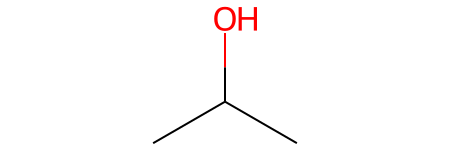

In [10]:
Chem.MolFromSmiles("OC(C)C")

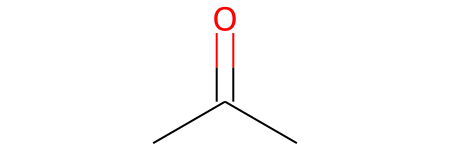

In [11]:
Chem.MolFromSmiles(solute) #OCCN

### Solvent

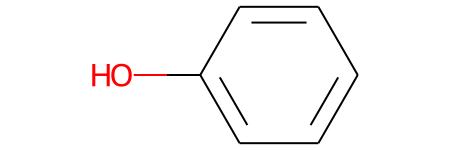

In [12]:
Chem.MolFromSmiles(solvent) #OCC

### Interaction map

Text(0.5, 15.0, 'Solvent')

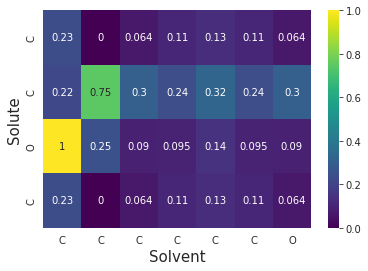

In [14]:
sns.heatmap(
    interaction_map,
    annot=True,
    xticklabels=list(map(lambda x: x.GetSymbol(), list(Chem.MolFromSmiles(solvent).GetAtoms()))),
    yticklabels=list(map(lambda x: x.GetSymbol(), list(Chem.MolFromSmiles(solute).GetAtoms()))),
    cmap='viridis'
)
plt.ylabel('Solute',size='15')
plt.xlabel('Solvent',size='15')